### Model (DGP):

fall into one of the K sub-models $N(\mu_k, \sigma_k)$, each with prob $\alpha_k$

$$ N(\mu_k, \sigma_k) = \frac{1}{\sqrt{2\pi} \sigma_k} \exp^{\frac{(x - \mu_k)^2}{2 \sigma_k^2}} $$

$$ \sum_k \alpha_k = 1 $$

latent var Z is "fall into k-th submodel"

param $\theta$ is $(\alpha_k, \mu_k, \sigma_k)$ for $k \in \{1, \cdots, K \}$

$$ Q(\theta, \theta^{(t)}) = \sum_z \log P(Y,Z | \theta) * P(Z|Y, \theta^{(t)})$$

samples $i$ are independent, change $\sum_i$ and $\sum_z$

$$ Q(\theta, \theta^{(t)})
= \sum_{i=1}^{m} \sum_{k=1}^{K} \Big\{ 
    \Big[
        \log\alpha_k - \log \sqrt{2\pi} - \log \sigma_k - \frac{(x - \mu_k)^2}{2 \sigma_k^2}
    \Big]  \hat\gamma_{i,k}^{(t)}
  \Big\}
$$

$$ \hat\gamma_{i,k}^{(t)}  \overset{def}{=} Prob(Z_i = k | X, \theta^{(t)}) $$

Optimization:

$$ \max_{\theta} \Lambda(\theta) = Q(\theta, \theta^{(t)}) - \lambda(1 - \sum_k \alpha_k) $$

$$ \partial \Lambda / \partial \alpha_k  = ... \overset{Let}{=} 0 $$
$$ \partial \Lambda / \partial \mu_k     = ... \overset{Let}{=} 0 $$
$$ \partial \Lambda / \partial \sigma_k  = ... \overset{Let}{=} 0 $$

got

$$ \begin{align}
  \alpha_k^{(t+1)}    &= \textbf{mean}(\hat\gamma_{i,k}^{(t)}) \\
  \mu_k^{(t+1)}       &= \textbf{weighted.mean}(x_i,             &\textbf{weight}=\hat\gamma_{i,k}^{(t)}) \\
  \sigma_k^{(t+1)}    &= \textbf{weighted.mean}((x_i - \mu_k^{(t+1)})^2, &\textbf{weight}=\hat\gamma_{i,k}^{(t)}) 
\end{align}$$
where
$$ \hat\gamma_{i,k}^{(t)} = \frac{\alpha_k^{(t)} N(x_i, \mu_k^{(t)}, \sigma_k^{(t)} )}{\sum_k ...} $$

## Empirical results:

1. intuitive: sigma should be less than diff(mu), otherwise difficult to seperate
    - but set true sigma very small does NOT seems help. TODO
2. ossilate
3. initial value matters

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [4]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [256]:
# theta

m = 10000
alpha = np.array([0.3, 0.7])

mu = np.array([160, 175])
sigma = np.array([10, 5])
K = alpha.shape[0]

m, K
alpha
mu
sigma

(10000, 2)

array([0.3, 0.7])

array([160, 175])

array([10,  5])

In [257]:
# data
Z = np.random.choice(K, replace=True, size=m)
X = np.array([np.random.normal(mu[z], sigma[z]) for z in Z])

Z[:10]
X[:10]

array([0, 0, 1, 0, 0, 1, 1, 1, 0, 1])

array([164.02860983, 144.31686416, 171.22775337, 162.26018067,
       161.03741474, 175.77639318, 178.41821102, 164.55857276,
       178.00300555, 175.74548016])

In [258]:
def normoal_pdf(x, mu_, sig_):
    return 1 / (np.sqrt(2 * np.pi) * sig_) * np.exp((x - mu_) ** 2 / (2 * sig_ ** 2))


def GaussianMixtureModel(X, init=None, max_iteration=1e2, torlance=1e-3):
    alpha_t = init['alpha']     # np.array([0.3, 0.7])
    mu_t = init['mu']           # np.array([160, 180])
    sigma_t = init['sigma']     # np.array([3, 9])
    
    t = 0
    iter_history = []
    
    while True:
        # gamma^(t) = \frac{ ..alpha*N(x,u,sigma).. }{ \sum .... }
        submodel_prob_matrix = np.array([
            [a_ * normoal_pdf(x, mu_, sig_) for x in X] for a_, mu_, sig_ in zip(alpha_t, mu_t, sigma_t)
        ])
        gamma_t = submodel_prob_matrix / np.sum(submodel_prob_matrix, axis=0)

#         if not np.allclose(np.sum(gamma_t, axis=0),1):
#             import pdb; pdb.set_trace()        
            
        alpha_prev, mu_prev, sigma_prev = alpha_t, mu_t, sigma_t
        
        alpha_t = np.mean(gamma_t, axis=1)
        mu_t = np.array([np.average(X, weights=gamma_t[k]) for k in range(K)])
        sigma_t = np.sqrt(np.array([np.average((X - mu_t[k]) ** 2, weights=gamma_t[k]) for k in range(K)]))
        
        t += 1
        
        # iteration history
        # should handle "ossilation" problem. Simplest case K=2:
        idx = np.argmax(mu_t)
        iter_history.append({
            't': t,
            'alpha': alpha_t[idx], 
            'mu': mu_t[idx], 
            'sigma': sigma_t[idx], 
        })
        
        b_stop = np.linalg.norm(alpha_t - alpha_prev, 2) < torlance and \
            np.linalg.norm(sigma_t - sigma_prev, 2) < torlance and \
            np.linalg.norm(mu_t - mu_prev, 2) < torlance

        if b_stop or t > max_iteration:
            print('stop. #iter: ', t)
            print(alpha_prev, mu_prev, sigma_prev)
            print(alpha_t, mu_t, sigma_t)
            break
        
    return alpha_t, mu_t, sigma_t, iter_history
            
        

In [259]:
print('true param:')
print(mu, sigma, alpha)
print('============================')

init =  {
    'mu':    np.array([155, 180]),
    'sigma': np.array([5, 5 ]   ), 
    'alpha': np.array([0.3, 0.7]),
}

_, _, _, iter_history = GaussianMixtureModel(X, init, max_iteration=50, torlance=1)

true param:
[160 175] [10  5] [0.3 0.7]
stop. #iter:  51
[0.7424241 0.2575759] [164.64853211 175.75650939] [11.08580473  3.62198299]
[0.25757585 0.74242415] [175.75650954 164.6485328 ] [ 3.62198224 11.0858048 ]


In [260]:
df = pd.DataFrame(iter_history)
df

,alpha,mu,sigma,t
0,0.548503,175.557444,4.555964,1
1,0.436695,176.264215,4.534897,2
2,0.335087,176.474631,4.342915,3
3,0.299693,176.278849,4.154004,4
4,0.288729,176.098246,4.021742,5
5,0.279930,175.984466,3.924190,6
6,0.274369,175.908231,3.852296,7
7,0.270174,175.858081,3.798200,8
8,0.267155,175.824476,3.757303,9
9,0.264873,175.801986,3.726119,10


Text(0.5, 1.0, 'alpha')

Text(0.5, 1.0, 'mu')

Text(0.5, 1.0, 'sigma')

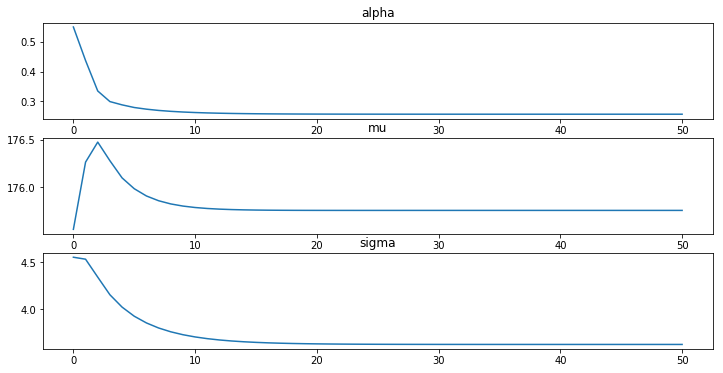

In [261]:
fig, axs = plt.subplots(3, 1, figsize=(12, 6))
axs[0].plot(df['alpha']  , label='alpha')
axs[0].set_title('alpha')
axs[1].plot(df['mu']     , label='mu')
axs[1].set_title('mu')
axs[2].plot(df['sigma']  , label='sigma')
axs[2].set_title('sigma')

(array([  1.,   0.,   0.,   0.,   0.,   0.,   3.,   2.,   5.,  14.,  11.,
         19.,  26.,  40.,  47.,  69.,  78., 134., 135., 144., 203., 227.,
        220., 276., 291., 295., 287., 321., 318., 366., 361., 391., 432.,
        531., 634., 740., 651., 685., 566., 480., 378., 229., 166., 106.,
         58.,  29.,  17.,   8.,   5.,   1.]),
 array([119.44910567, 120.95632485, 122.46354403, 123.97076322,
        125.4779824 , 126.98520158, 128.49242076, 129.99963995,
        131.50685913, 133.01407831, 134.52129749, 136.02851668,
        137.53573586, 139.04295504, 140.55017422, 142.0573934 ,
        143.56461259, 145.07183177, 146.57905095, 148.08627013,
        149.59348932, 151.1007085 , 152.60792768, 154.11514686,
        155.62236605, 157.12958523, 158.63680441, 160.14402359,
        161.65124278, 163.15846196, 164.66568114, 166.17290032,
        167.68011951, 169.18733869, 170.69455787, 172.20177705,
        173.70899623, 175.21621542, 176.7234346 , 178.23065378,
        179.737872

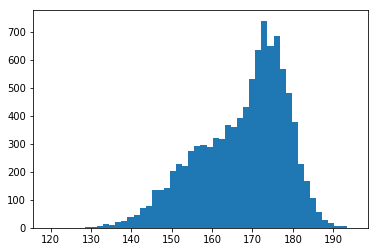

In [262]:
plt.hist(X, bins=50)

In [263]:
print('true param:')
print(mu, sigma, alpha)
print('============================')

true param:
[160 175] [10  5] [0.3 0.7]
